<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/04_LogisticDelay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [1]:
import pandas as pd

df = pd.read_csv('SupplyChainDataset_eda.csv', encoding = 'latin-1')

# Dataprocessing

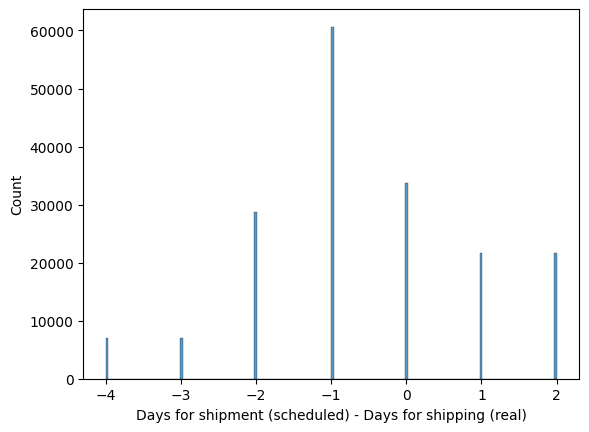

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Days for shipment (scheduled)'] - df['Days for shipping (real)'])
plt.xlabel('Days for shipment (scheduled) - Days for shipping (real)')
plt.ylabel('Count')
plt.show()

In [3]:
df['Delay'] = df['Days for shipment (scheduled)'] - df['Days for shipping (real)']

for i in range(0, len(df)):
  if df['Delay'][i] < 0:
    df['Delay'][i] = 1
  else:
    df['Delay'][i] = 0

df['Delay'].value_counts()

/var/folders/hp/p_1k882j55xd617n87y36zt40000gn/T/ipykernel_30158/1479388383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delay'][i] = 0
/var/folders/hp/p_1k882j55xd617n87y36zt40000gn/T/ipykernel_30158/1479388383.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delay'][i] = 1


1    103400
0     77119
Name: Delay, dtype: int64

In [4]:
df.drop(['Delivery Status', 'Late_delivery_risk', 'Days for shipment (scheduled)', 
         'Days for shipping (real)', 'Order Status'], axis = 1, inplace = True)

In [5]:
from datetime import datetime

df['order date'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date'] = pd.to_datetime(df['shipping date (DateOrders)'])

df['order date'] = df['order date'].apply(lambda x: x.timestamp())
df['shipping date'] = df['shipping date'].apply(lambda x: x.timestamp())

df.drop(['order date (DateOrders)', 'shipping date (DateOrders)'], axis = 1, inplace = True)

df.to_csv('SupplyChainDataset_delay.csv', index = False)

# Encoding

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('Delay', axis = 1)
y = df['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 4, 5, 8]

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

In [10]:
from sklearn.preprocessing import StandardScaler

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

scaler = StandardScaler()

X_train[X_train.columns[23:]] = scaler.fit_transform(X_train[X_train.columns[23:]])
X_test[X_test.columns[23:]] = scaler.transform(X_test[X_test.columns[23:]])

In [11]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Models

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import pickle

lr = LogisticRegression(C=10, solver='lbfgs', max_iter=200)

lr.fit(X_train, y_train)

/Users/giacomorossi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, max_iter=200)

In [13]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

y_pred = lr.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9540494128074452
Recall: 0.9826527628886074
Precision: 0.9393078392100238
F1: 0.9604915339001214
Confusion Matrix: 
[[14279  1303]
 [  356 20166]]
